# Project Title: Group 7

## Libraries and settings

## 1. Imports & CSV einlesen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

import sqlite3


In [2]:
# CSV einlesen (robust: suche in ./data/ mit Fallback)
from pathlib import Path
import pandas as pd

candidates = [
    Path('./data/2025-12-01_HouseMarketAG_ImmoScout24.csv'),
    Path('./data/test.csv'),
    Path('./data/RentalapartmentsAG.csv')
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    files = list(Path('./data').glob('*.csv'))
    if files:
        csv_path = files[0]
    else:
        raise FileNotFoundError("Keine CSV im ./data Verzeichnis gefunden. Bitte Datei verschieben oder Pfad anpassen.")
print('Lade CSV:', csv_path)
# Lade als strings, low_memory=False stabilisiert Lesen großer Dateien
df = pd.read_csv(csv_path, dtype=str, low_memory=False)

# Kurze Prüfung / Ausgabe
print(df.head())
print('\nSpalten:', df.columns.tolist())

Lade CSV: data/2025-12-01_HouseMarketAG_ImmoScout24.csv
  web_scraper_order                              web_scraper_start_url  \
0      1765116379-1  https://www.immoscout24.ch/de/haus/kaufen/kant...   
1      1765116383-2  https://www.immoscout24.ch/de/haus/kaufen/kant...   
2      1765116383-3  https://www.immoscout24.ch/de/haus/kaufen/kant...   
3      1765116383-4  https://www.immoscout24.ch/de/haus/kaufen/kant...   
4      1765116383-5  https://www.immoscout24.ch/de/haus/kaufen/kant...   

          adress_raw          price_raw squaremeter_raw   rooms_raw  
0         8967 Widen  Preis auf Anfrage             NaN   11 Zimmer  
1  5452 Oberrohrdorf    CHF 2’490’000.–           221m²  5.5 Zimmer  
2          5034 Suhr    CHF 1’650’000.–           200m²    8 Zimmer  
3      5043 Holziken   CHF 14’500’000.–             NaN         NaN  
4     4325 Schupfart    CHF 2’688’000.–             NaN       405m²  

Spalten: ['web_scraper_order', 'web_scraper_start_url', 'adress_raw', 'price_r

## 2. Datenbereinigung (sehr wichtig – behebt NaN-Problem!)

#### 2.1 "Preis auf Anfrage" entfernen

In [3]:
df = df[df["price_raw"] != "Preis auf Anfrage"].copy()


#### 2.2 price_raw korrekt bereinigen (CHF entfernen)

In [4]:
df["price_raw"] = (
    df["price_raw"]
    .astype(str)
    .str.replace("CHF", "", regex=False)
    .str.replace("’", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.replace("–", "", regex=False)
    .str.strip()
)

df["price_raw"] = pd.to_numeric(df["price_raw"], errors="coerce")


#### 2.3 squaremeter_raw korrekt bereinigen

In [5]:
df["squaremeter_raw"] = (
    df["squaremeter_raw"]
    .astype(str)
    .str.replace("m²", "", regex=False)
    .str.replace(" m2", "", regex=False)
    .str.replace("m2", "", regex=False)
    .str.strip()
)

df["squaremeter_raw"] = pd.to_numeric(df["squaremeter_raw"], errors="coerce")


#### 2.4 rooms_raw korrekt bereinigen

In [6]:
df["rooms_raw"] = (
    df["rooms_raw"]
    .astype(str)
    .str.replace("Zimmer", "", regex=False)
    .str.replace("Zi", "", regex=False)
    .str.strip()
)

df["rooms_raw"] = pd.to_numeric(df["rooms_raw"], errors="coerce")


#### 2.5 Fehlende Werte mit Mean Imputation ersetzen

In [7]:
for col in ["price_raw", "squaremeter_raw", "rooms_raw"]:
    df[col].fillna(df[col].mean(), inplace=True)

print(df[["price_raw", "squaremeter_raw", "rooms_raw"]].isna().sum())


price_raw          0
squaremeter_raw    0
rooms_raw          0
dtype: int64


/tmp/ipykernel_68860/1412575188.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


#### 2.6 Neue Variable: Preis pro m²

In [8]:
df["price_per_sqm"] = df["price_raw"] / df["squaremeter_raw"]


#### 2.7 PLZ aus Adresse extrahieren (für Regionenvergleich)

In [9]:
import re

def extract_plz(address):
    if isinstance(address, str):
        match = re.search(r"\b(\d{4})\b", address)
        if match:
            return match.group(1)
    return np.nan

df["plz"] = df["adress_raw"].apply(extract_plz)


#### 2.8 Bereinigte CSV speichern

In [10]:
df.to_csv("HouseMarketAG_ImmoScout24_cleaned.csv", index=False)


## 3. SQLite-Datenbank erstellen & Daten speichern

In [11]:
conn = sqlite3.connect("HouseMarketAG.db")

df.to_sql("houses_table", conn, if_exists="replace", index=False)

print("✅ Database & table created successfully")


✅ Database & table created successfully


## (4) EDA – Deskriptive Statistiken & Visualisierungen

#### 4.1 Basisstatistik

In [12]:
print(df[["price_raw", "squaremeter_raw", "rooms_raw", "price_per_sqm"]].describe())
print(df["plz"].value_counts().head())


          price_raw  squaremeter_raw   rooms_raw  price_per_sqm
count  5.450000e+02       545.000000  545.000000     545.000000
mean   1.533131e+06       195.649573    6.529586    8197.989653
std    9.529238e+05        92.622400    3.274247    4327.918466
min    4.390000e+05        74.000000    3.500000    1838.942308
25%    1.059000e+06       147.000000    5.500000    6171.548117
50%    1.390000e+06       181.000000    5.500000    7633.333333
75%    1.735000e+06       203.000000    6.529586    9420.289855
max    1.450000e+07       927.000000   54.000000   74112.096457
plz
5610    24
5734    20
4852    12
5452    10
4313    10
Name: count, dtype: int64


#### 4.2 Histogramme

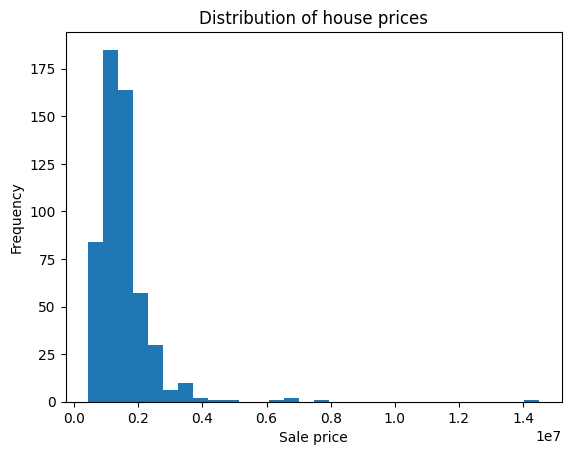

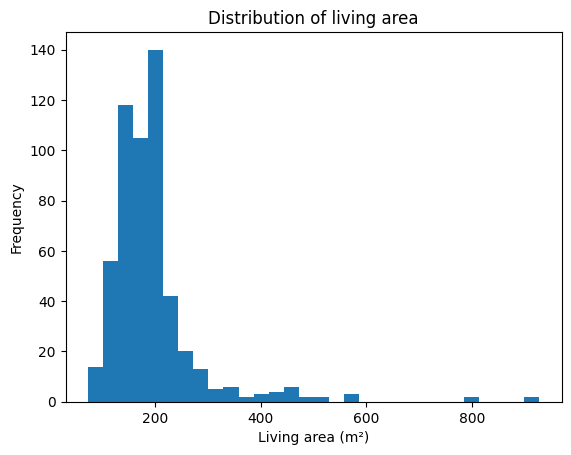

In [13]:
# House prices
plt.figure()
plt.hist(df["price_raw"], bins=30)
plt.xlabel("Sale price")
plt.ylabel("Frequency")
plt.title("Distribution of house prices")
plt.show()

# Living area
plt.figure()
plt.hist(df["squaremeter_raw"], bins=30)
plt.xlabel("Living area (m²)")
plt.ylabel("Frequency")
plt.title("Distribution of living area")
plt.show()


#### 4.3 Boxplots

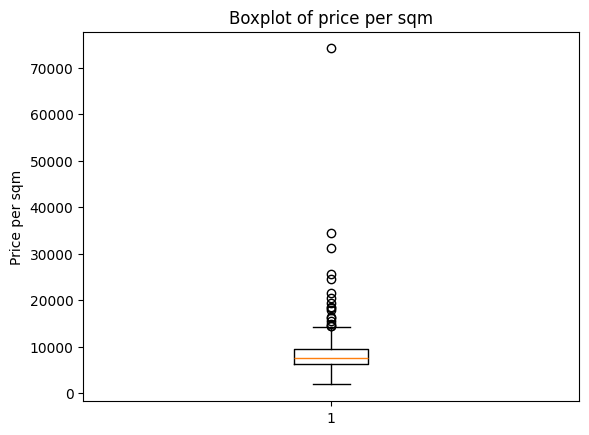

In [14]:
# Price per sqm
plt.figure()
plt.boxplot(df["price_per_sqm"].dropna())
plt.ylabel("Price per sqm")
plt.title("Boxplot of price per sqm")
plt.show()


#### 4.4 Scatterplot: Wohnfläche vs. Preis

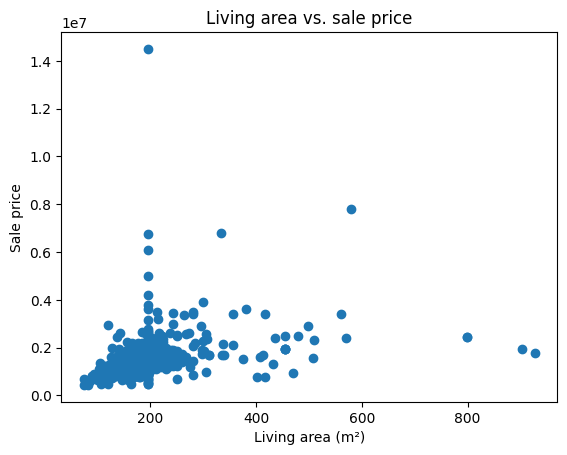

In [15]:
plt.figure()
plt.scatter(df["squaremeter_raw"], df["price_raw"])
plt.xlabel("Living area (m²)")
plt.ylabel("Sale price")
plt.title("Living area vs. sale price")
plt.show()


#### 4.5 Durchschnittspreis nach PLZ

plz
5043    14500000.0
8966     5700000.0
5630     4622500.0
5210     4610000.0
6042     3390000.0
Name: price_raw, dtype: float64


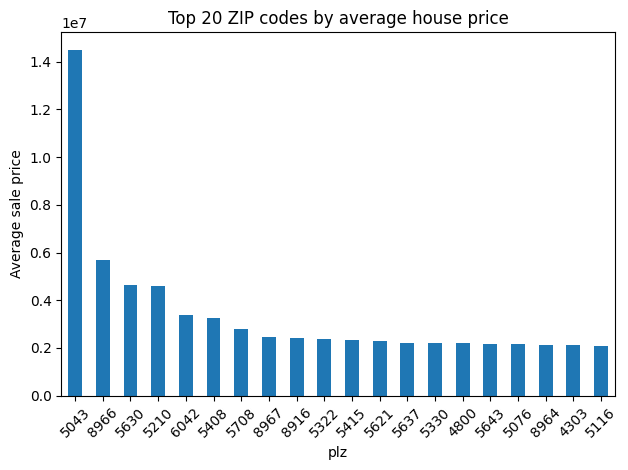

In [16]:
avg_price_by_plz = df.groupby("plz")["price_raw"].mean().sort_values(ascending=False)
print(avg_price_by_plz.head())

plt.figure()
avg_price_by_plz.head(20).plot(kind="bar")
plt.ylabel("Average sale price")
plt.title("Top 20 ZIP codes by average house price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


(4 / 6 / Additional) Korrelation (mit p-Wert)

In [17]:
corr, p_val = pearsonr(df["squaremeter_raw"], df["price_raw"])
print(f"Pearson correlation (sqm vs. price): {corr:.3f}, p-value: {p_val:.3e}")


Pearson correlation (sqm vs. price): 0.332, p-value: 1.883e-15


## (5) Modelle: Lineare Regression & Random Forest

#### 5.1 Feature-Matrix & Zielvariable

In [18]:
features = ["squaremeter_raw", "rooms_raw"]
X = df[features]
y = df["price_raw"]


5.2 Train-Test-Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#### 5.3 Multiple lineare Regression

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
# Compute RMSE in a way compatible with older sklearn versions
try:
    # newer sklearn supports squared=False to return RMSE directly
    rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)
except TypeError:
    # fallback: compute MSE then take sqrt
    rmse_lin = mean_squared_error(y_test, y_pred_lin) ** 0.5

print("Linear Regression:")
print("R²:", r2_lin)
print("RMSE:", rmse_lin)
print("Coefficients:", dict(zip(features, lin_reg.coef_)))
print("Intercept:", lin_reg.intercept_)

Linear Regression:
R²: 0.101848113642246
RMSE: 1491228.3112918825
Coefficients: {'squaremeter_raw': np.float64(2464.0049679532317), 'rooms_raw': np.float64(15488.133552018106)}
Intercept: 912541.3025036629


#### 5.4 Random Forest Regression

In [21]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
 )
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
# Compute RMSE with compatibility fallback for older sklearn versions
try:
    rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
except TypeError:
    rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5

print("Random Forest:")
print("R²:", r2_rf)
print("RMSE:", rmse_rf)
print("Feature importances:", dict(zip(features, rf.feature_importances_)))

Random Forest:
R²: 0.13639604063385002
RMSE: 1462266.5972741323
Feature importances: {'squaremeter_raw': np.float64(0.7595150166616014), 'rooms_raw': np.float64(0.24048498333839863)}


#### (6) Modellbewertung – Vergleich

In [22]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R2": [r2_lin, r2_rf],
    "RMSE": [rmse_lin, rmse_rf]
})
print(results)


               Model        R2          RMSE
0  Linear Regression  0.101848  1.491228e+06
1      Random Forest  0.136396  1.462267e+06


#### Additional (1): Szenario – +20 m² Wohnfläche

###### Beispiel: Wie verändert sich der erwartete Preis, wenn ein Haus 20 m² grösser wäre (gleiche Zimmerzahl, gleiche Koeffizienten aus der linearen Regression)?

In [23]:
# Beispielhaus
example_sqm = 120
example_rooms = 5

base_price = lin_reg.predict([[example_sqm, example_rooms]])[0]
plus20_price = lin_reg.predict([[example_sqm + 20, example_rooms]])[0]

print(f"Predicted price at {example_sqm} m²:     {base_price:,.0f}")
print(f"Predicted price at {example_sqm+20} m²: {plus20_price:,.0f}")
print(f"Difference for +20 m²: {plus20_price - base_price:,.0f}")


Predicted price at 120 m²:     1,285,663
Predicted price at 140 m²: 1,334,943
Difference for +20 m²: 49,280


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


##### Additional (2): Beispiel MySQL

###### Durchschnittspreis pro Zimmeranzahl

In [24]:
sql_query = """
SELECT rooms_raw,
       AVG(price_raw) AS avg_price
FROM houses_table
GROUP BY rooms_raw
ORDER BY rooms_raw;
"""

avg_price_mysql = pd.read_sql(sql_query, engine)
print(avg_price_mysql)


NameError: name 'engine' is not defined

###### Grosse Häuser filtern (z. B. Fix & Flip Kandidaten)

In [ ]:
sql_query_big = """
SELECT *
FROM houses_table
WHERE squaremeter_raw >= 150
  AND rooms_raw >= 5;
"""

big_houses_mysql = pd.read_sql(sql_query_big, engine)
print(big_houses_mysql.head())


NameError: name 'engine' is not defined